In [1]:
import torch
import numpy as np
import json
import matplotlib.pyplot as plt
import cv2
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms



link: https://pypi.org/project/cityscapesScripts/


In [20]:
pip install cityscapesScripts

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26325 sha256=b1820737ac995bcb31abb740880f44e174a45044fbdec4a1f2923379b0cad244
  Stored in directory: c:\users\dyna\appdata\local\pip\cache\wheels\12\98\52\2bffe242a9a487f00886e43b8ed8dac46456702e11a0d6abef
Successfully built typing
Note: you may need to restart the kernel to use updated packages.


***config files***

In [13]:
config_file = "../cfgs/train.json"

In [11]:
with open(config_file) as fp:
    cfg = json.load(fp)

***Data augmentation and pre-processing***

In [12]:
arch_name = cfg["arch"]["arch_name"]
experiment_name = cfg["model_stuff"]["exp_name"]
MODEL_PATH = "../Experiments/{}/best.pth".format(experiment_name)
cfg["arch"]["arch_kwargs"]["pretrained"] = False
input_size = cfg["train"]["width"], cfg["train"]["height"]

cfg["data"]["train_data"] = "../" + cfg["data"]["train_data"]
cfg["data"]["valid_data"] = "../" + cfg["data"]["valid_data"]
cfg["data"]["train_root"] = "../" + cfg["data"]["train_root"]
cfg["data"]["label_root"] = "../" + cfg["data"]["label_root"]

train_file = cfg["data"]["train_data"]
val_file = cfg["data"]["valid_data"]
train_root = cfg["data"]["train_root"]
label_root = cfg["data"]["label_root"]


In [6]:
model = get_network(cfg["data"]["input_channels"], cfg["data"]["num_classes"], cfg["arch"]["arch_name"], cfg["arch"]["arch_kwargs"])
model.cuda()
model.load_state_dict(torch.load(MODEL_PATH)["model_weights"])

Initializing ERFNet...


<All keys matched successfully>

In [7]:
train_list, val_list = get_list_files(train_file,val_file)    

***Input dimensions for training configurations***

In [11]:
cfg["train"]["width"], cfg["train"]["height"] = 512, 512 
input_size = cfg["train"]["width"], cfg["train"]["height"]

In [12]:
train_dataset = LaneDataset(cfg, augmentations = True , train=True, mode="train")

In [18]:
train_choices = np.random.randint(0,len(train_dataset),5)

***Edge transformation using canny***

In [6]:
# Libraries for working with image processing
import numpy as np
import pandas as pd
import cv2

def frame_processor(image):
	"""
	Process the input frame to detect lane lines.
	Parameters:
		image: image of a road where one wants to detect lane lines
		(we will be passing frames of video to this function)
	"""
	# convert the RGB image to Gray scale
	grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	# applying gaussian Blur which removes noise from the image 
	# and focuses on our region of interest
	# size of gaussian kernel
	kernel_size = 5
	# Applying gaussian blur to remove noise from the frames
	blur = cv2.GaussianBlur(grayscale, (kernel_size, kernel_size), 0)
	# first threshold for the hysteresis procedure
	low_t = 50
	# second threshold for the hysteresis procedure 
	high_t = 150
	# applying canny edge detection and save edges in a variable
	edges = cv2.Canny(blur, low_t, high_t)
	# since we are getting too many edges from our image, we apply 
	# a mask polygon to only focus on the road
	# Will explain Region selection in detail in further steps
	region = region_selection(edges)
	# Applying hough transform to get straight lines from our image 
	# and find the lane lines
	# Will explain Hough Transform in detail in further steps
	hough = hough_transform(region)
	#lastly we draw the lines on our resulting frame and return it as output 
	result = draw_lane_lines(image, lane_lines(image, hough))
	return result


In [7]:
def hough_transform(image):
	"""
	Determine and cut the region of interest in the input image.
	Parameter:
		image: grayscale image which should be an output from the edge detector
	"""
	# Distance resolution of the accumulator in pixels.
	rho = 1			
	# Angle resolution of the accumulator in radians.
	theta = np.pi/180
	# Only lines that are greater than threshold will be returned.
	threshold = 20	
	# Line segments shorter than that are rejected.
	minLineLength = 20
	# Maximum allowed gap between points on the same line to link them
	maxLineGap = 500	
	# function returns an array containing dimensions of straight lines 
	# appearing in the input image
	return cv2.HoughLinesP(image, rho = rho, theta = theta, threshold = threshold,
						minLineLength = minLineLength, maxLineGap = maxLineGap)


In [17]:
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
#Import everything needed to edit/save/watch video clips
from moviepy import editor
import moviepy

def region_selection(image):
	"""
	Determine and cut the region of interest in the input image.
	Parameters:
		image: we pass here the output from canny where we have 
		identified edges in the frame
	"""
	# create an array of the same size as of the input image 
	mask = np.zeros_like(image) 
	# if you pass an image with more then one channel
	if len(image.shape) > 2:
		channel_count = image.shape[2]
		ignore_mask_color = (255,) * channel_count
	# our image only has one channel so it will go under "else"
	else:
		# color of the mask polygon (white)
		ignore_mask_color = 255
	# creating a polygon to focus only on the road in the picture
	# we have created this polygon in accordance to how the camera was placed
	rows, cols = image.shape[:2]
	bottom_left = [cols * 0.1, rows * 0.95]
	top_left	 = [cols * 0.4, rows * 0.6]
	bottom_right = [cols * 0.9, rows * 0.95]
	top_right = [cols * 0.6, rows * 0.6]
	vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
	# filling the polygon with white color and generating the final mask
	cv2.fillPoly(mask, vertices, ignore_mask_color)
	# performing Bitwise AND on the input image and mask to get only the edges on the road
	masked_image = cv2.bitwise_and(image, mask)
	return masked_image

def hough_transform(image):
	"""
	Determine and cut the region of interest in the input image.
	Parameter:
		image: grayscale image which should be an output from the edge detector
	"""
	# Distance resolution of the accumulator in pixels.
	rho = 1			
	# Angle resolution of the accumulator in radians.
	theta = np.pi/180
	# Only lines that are greater than threshold will be returned.
	threshold = 20	
	# Line segments shorter than that are rejected.
	minLineLength = 20
	# Maximum allowed gap between points on the same line to link them
	maxLineGap = 500	
	# function returns an array containing dimensions of straight lines 
	# appearing in the input image
	return cv2.HoughLinesP(image, rho = rho, theta = theta, threshold = threshold,
						minLineLength = minLineLength, maxLineGap = maxLineGap)
	
def average_slope_intercept(lines):
	"""
	Find the slope and intercept of the left and right lanes of each image.
	Parameters:
		lines: output from Hough Transform
	"""
	left_lines = [] #(slope, intercept)
	left_weights = [] #(length,)
	right_lines = [] #(slope, intercept)
	right_weights = [] #(length,)
	
	for line in lines:
		for x1, y1, x2, y2 in line:
			if x1 == x2:
				continue
			# calculating slope of a line
			slope = (y2 - y1) / (x2 - x1)
			# calculating intercept of a line
			intercept = y1 - (slope * x1)
			# calculating length of a line
			length = np.sqrt(((y2 - y1) ** 2) + ((x2 - x1) ** 2))
			# slope of left lane is negative and for right lane slope is positive
			if slope < 0:
				left_lines.append((slope, intercept))
				left_weights.append((length))
			else:
				right_lines.append((slope, intercept))
				right_weights.append((length))
	# 
	left_lane = np.dot(left_weights, left_lines) / np.sum(left_weights) if len(left_weights) > 0 else None
	right_lane = np.dot(right_weights, right_lines) / np.sum(right_weights) if len(right_weights) > 0 else None
	return left_lane, right_lane

def pixel_points(y1, y2, line):
	"""
	Converts the slope and intercept of each line into pixel points.
		Parameters:
			y1: y-value of the line's starting point.
			y2: y-value of the line's end point.
			line: The slope and intercept of the line.
	"""
	if line is None:
		return None
	slope, intercept = line
	x1 = int((y1 - intercept)/slope)
	x2 = int((y2 - intercept)/slope)
	y1 = int(y1)
	y2 = int(y2)
	return ((x1, y1), (x2, y2))

def lane_lines(image, lines):
	"""
	Create full lenght lines from pixel points.
		Parameters:
			image: The input test image.
			lines: The output lines from Hough Transform.
	"""
	left_lane, right_lane = average_slope_intercept(lines)
	y1 = image.shape[0]
	y2 = y1 * 0.6
	left_line = pixel_points(y1, y2, left_lane)
	right_line = pixel_points(y1, y2, right_lane)
	return left_line, right_line

	
def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=12):
	"""
	Draw lines onto the input image.
		Parameters:
			image: The input test image (video frame in our case).
			lines: The output lines from Hough Transform.
			color (Default = red): Line color.
			thickness (Default = 12): Line thickness. 
	"""
	line_image = np.zeros_like(image)
	for line in lines:
		if line is not None:
			cv2.line(line_image, *line, color, thickness)
	return cv2.addWeighted(image, 1.0, line_image, 1.0, 0.0)

def frame_processor(image):
	"""
	Process the input frame to detect lane lines.
	Parameters:
		image: image of a road where one wants to detect lane lines
		(we will be passing frames of video to this function)
	"""
	# convert the RGB image to Gray scale
	grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	# applying gaussian Blur which removes noise from the image 
	# and focuses on our region of interest
	# size of gaussian kernel
	kernel_size = 5
	# Applying gaussian blur to remove noise from the frames
	blur = cv2.GaussianBlur(grayscale, (kernel_size, kernel_size), 0)
	# first threshold for the hysteresis procedure
	low_t = 50
	# second threshold for the hysteresis procedure 
	high_t = 150
	# applying canny edge detection and save edges in a variable
	edges = cv2.Canny(blur, low_t, high_t)
	# since we are getting too many edges from our image, we apply 
	# a mask polygon to only focus on the road
	# Will explain Region selection in detail in further steps
	region = region_selection(edges)
	# Applying hough transform to get straight lines from our image 
	# and find the lane lines
	# Will explain Hough Transform in detail in further steps
	hough = hough_transform(region)
	#lastly we draw the lines on our resulting frame and return it as output 
	result = draw_lane_lines(image, lane_lines(image, hough))
	return result

# driver function
def process_video(test_video, output_video):
	"""
	Read input video stream and produce a video file with detected lane lines.
	Parameters:
		test_video: location of input video file
		output_video: location where output video file is to be saved
	"""
	# read the video file using VideoFileClip without audio
	input_video = editor.VideoFileClip(test_video, audio=False)
	# apply the function "frame_processor" to each frame of the video
	# will give more detail about "frame_processor" in further steps
	# "processed" stores the output video
	processed = input_video.fl_image(frame_processor)
	# save the output video stream to an mp4 file
	processed.write_videofile(output_video, audio=False)
	
# calling driver function
process_video('input.mp4','output.mp4')


ModuleNotFoundError: No module named 'google.colab'

In [18]:
pip install collab


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for collab: filename=collab-1.0.198-py3-none-any.whl size=20113 sha256=d36eb009e14d8fdb1eace4fa6a5f37bc678a137372838bd28b463faf42ff8630
  Stored in directory: c:\users\dyna\appdata\local\pip\cache\wheels\f8\04\45\7c828bf96ac575e949c393d71ab91dd4ddbb61341f5244bfe9
Successfully built collab


In [15]:
def average_slope_intercept(lines):
	"""
	Find the slope and intercept of the left and right lanes of each image.
	Parameters:
		lines: output from Hough Transform
	"""
	left_lines = [] #(slope, intercept)
	left_weights = [] #(length,)
	right_lines = [] #(slope, intercept)
	right_weights = [] #(length,)
	
	for line in lines:
		for x1, y1, x2, y2 in line:
			if x1 == x2:
				continue
			# calculating slope of a line
			slope = (y2 - y1) / (x2 - x1)
			# calculating intercept of a line
			intercept = y1 - (slope * x1)
			# calculating length of a line
			length = np.sqrt(((y2 - y1) ** 2) + ((x2 - x1) ** 2))
			# slope of left lane is negative and for right lane slope is positive
			if slope < 0:
				left_lines.append((slope, intercept))
				left_weights.append((length))
			else:
				right_lines.append((slope, intercept))
				right_weights.append((length))
	# 
	left_lane = np.dot(left_weights, left_lines) / np.sum(left_weights) if len(left_weights) > 0 else None
	right_lane = np.dot(right_weights, right_lines) / np.sum(right_weights) if len(right_weights) > 0 else None
	return left_lane, right_lane

def pixel_points(y1, y2, line):
	"""
	Converts the slope and intercept of each line into pixel points.
		Parameters:
			y1: y-value of the line's starting point.
			y2: y-value of the line's end point.
			line: The slope and intercept of the line.
	"""
	if line is None:
		return None
	slope, intercept = line
	x1 = int((y1 - intercept)/slope)
	x2 = int((y2 - intercept)/slope)
	y1 = int(y1)
	y2 = int(y2)
	return ((x1, y1), (x2, y2))

def lane_lines(image, lines):
	"""
	Create full lenght lines from pixel points.
		Parameters:
			image: The input test image.
			lines: The output lines from Hough Transform.
	"""
	left_lane, right_lane = average_slope_intercept(lines)
	y1 = image.shape[0]
	y2 = y1 * 0.6
	left_line = pixel_points(y1, y2, left_lane)
	right_line = pixel_points(y1, y2, right_lane)
	return left_line, right_line

	
def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=12):
	"""
	Draw lines onto the input image.
		Parameters:
			image: The input test image (video frame in our case).
			lines: The output lines from Hough Transform.
			color (Default = red): Line color.
			thickness (Default = 12): Line thickness. 
	"""
	line_image = np.zeros_like(image)
	for line in lines:
		if line is not None:
			cv2.line(line_image, *line, color, thickness)
	return cv2.addWeighted(image, 1.0, line_image, 1.0, 0.0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IOU :0.2887233358726164


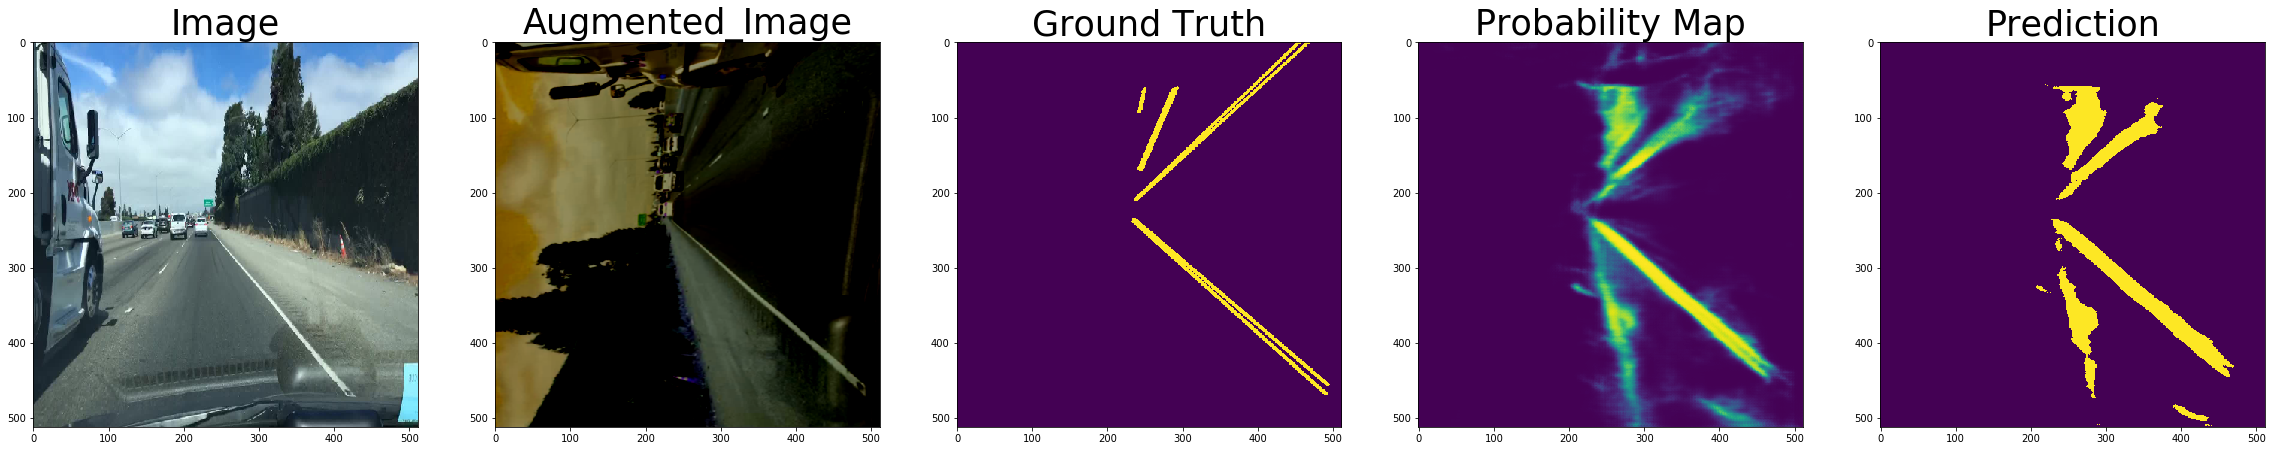

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IOU :0.065813405249861


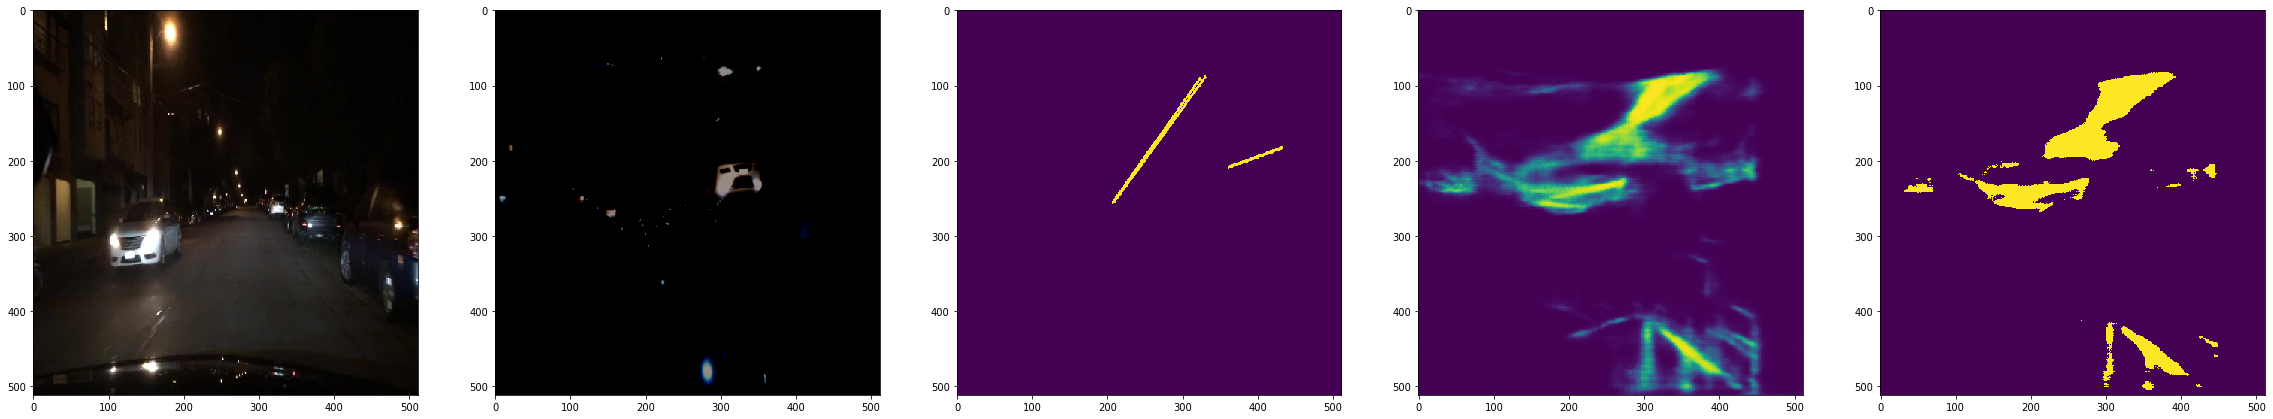

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IOU :0.31622927867942413


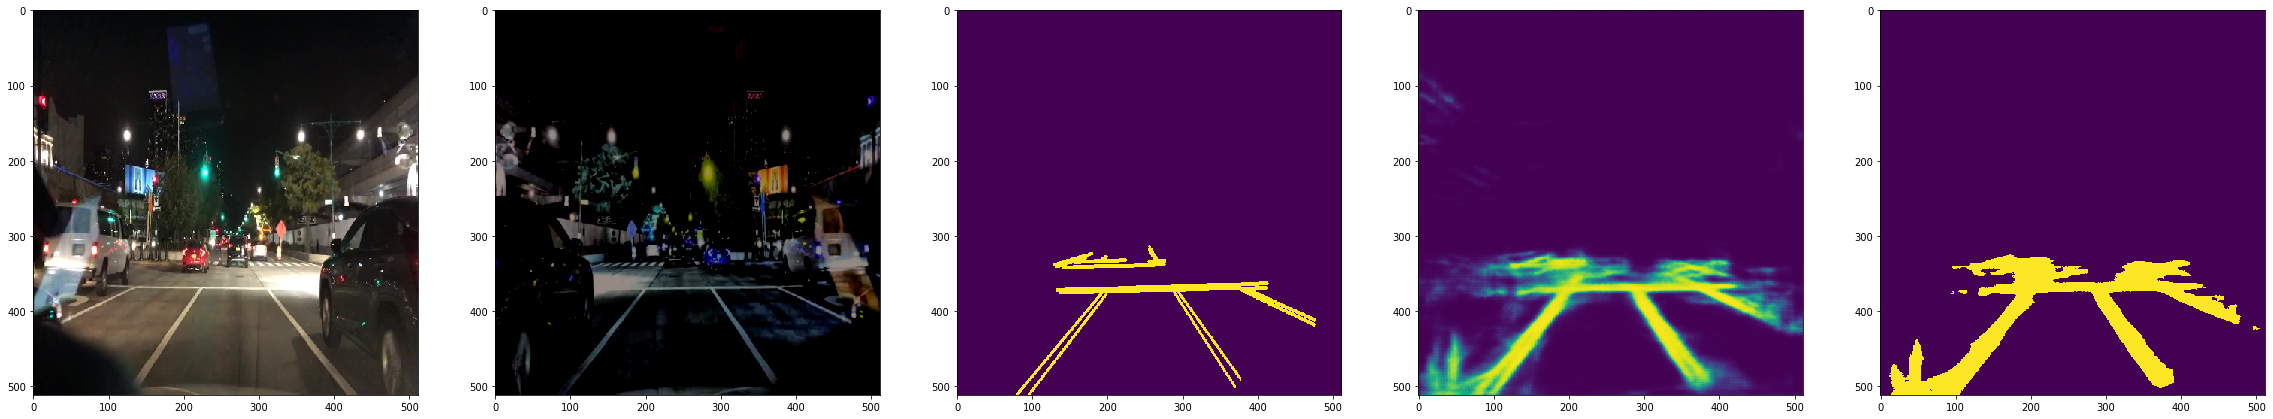

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IOU :0.22032347930562873


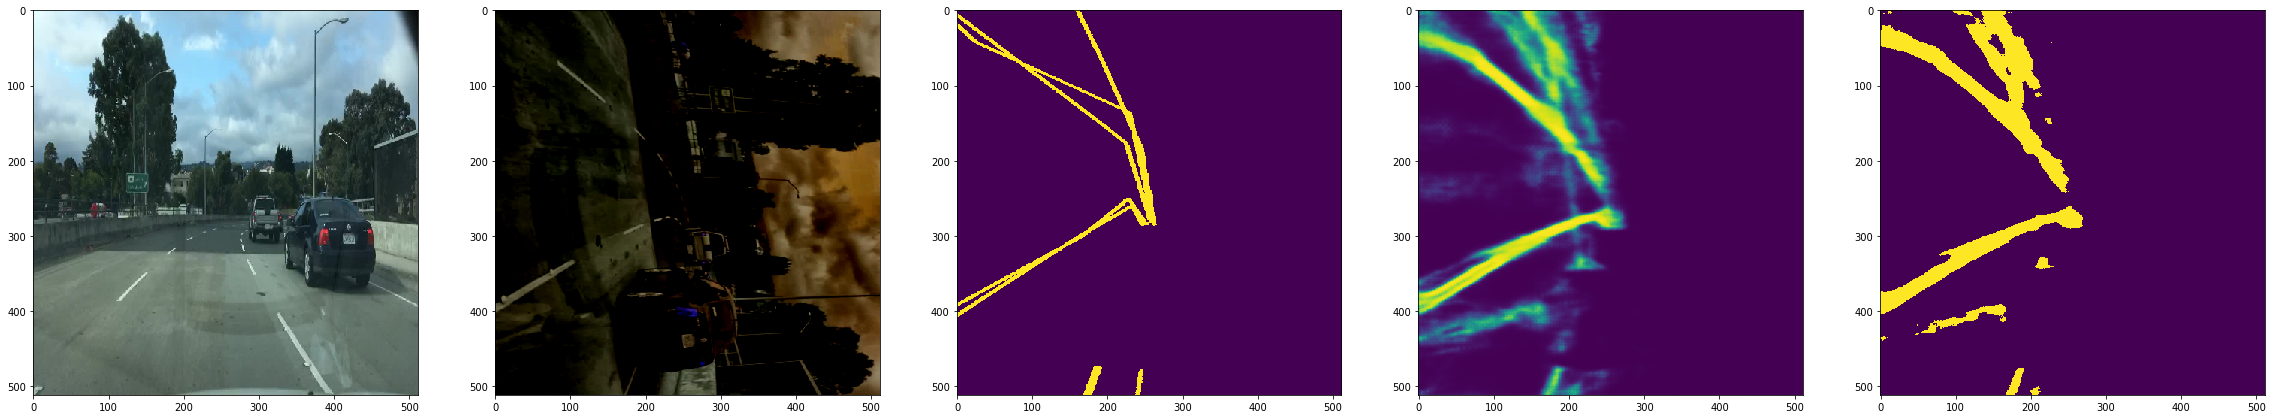

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IOU :0.10713944835796795


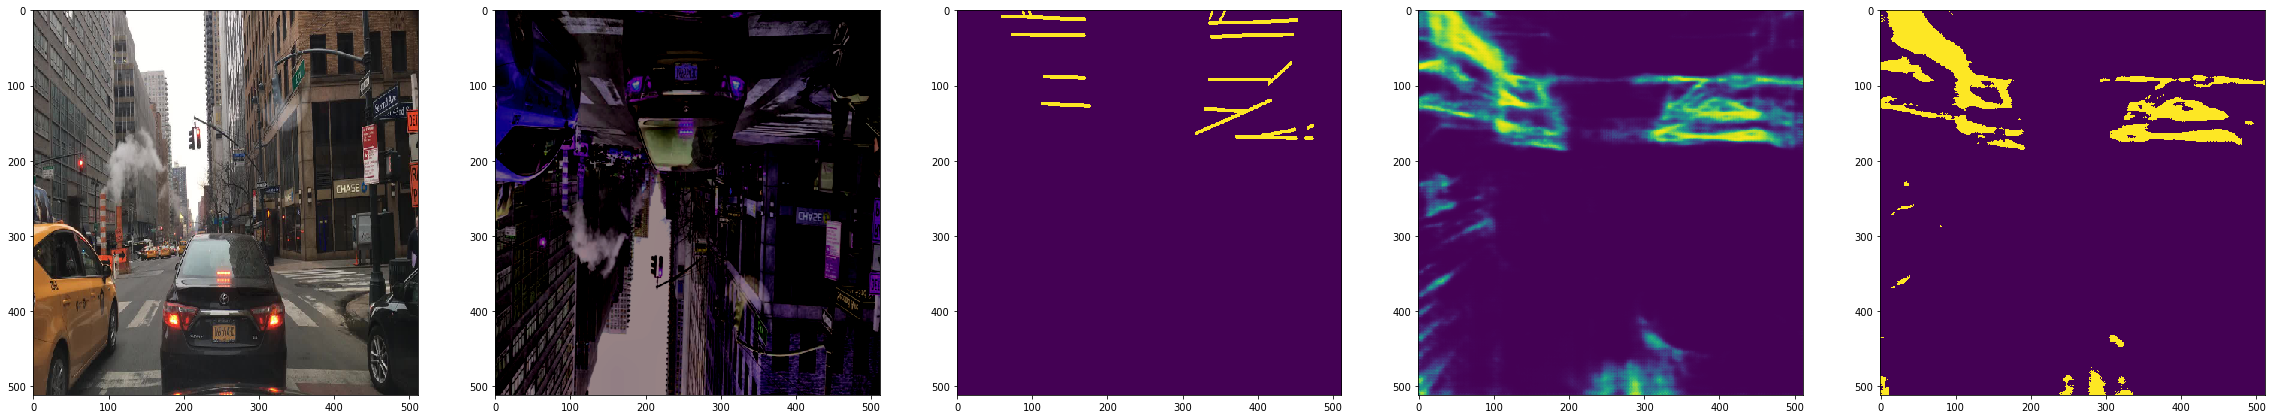

In [19]:
for i,index in enumerate(train_choices):
    
    img,mask = train_dataset[index]
    
    inputs = img.unsqueeze(0).cuda()
    targets = mask.unsqueeze(0).cuda()
       
    outputs = model(inputs)
       
    iou = fscore_batch(targets,outputs)
    print("IOU :{}".format(iou))
    
    prob_map = torch.nn.functional.softmax(outputs,dim=1)
    prob_map = prob_map.squeeze(0)
    prob_map = prob_map.cpu().detach().numpy()
        
    fig = plt.figure(figsize=(40,40))
    
    ax1 = fig.add_subplot(151)
    if not i:
        ax1.set_title('Image',fontsize=35 )
    image = Image.open(train_root + train_list[index])
    image = image.resize(input_size)
    plt.imshow(image)
    
    ax1 = fig.add_subplot(152)
    if not i:
        ax1.set_title('Augmented_Image',fontsize=35 )
    img_c = img.cpu().numpy()
    img_c = np.transpose(img_c,(1,2,0))
    plt.imshow(img_c)
    
    ax3 = fig.add_subplot(153)
    if not i:
        ax3.set_title('Ground Truth',fontsize= 35)
    targets = targets.squeeze(0).squeeze(0).cpu().numpy()
    plt.imshow(targets)
    
    ax4 = fig.add_subplot(154)
    if not i:
        ax4.set_title('Probability Map',fontsize= 35)
    _ , pred = torch.max(outputs,dim=1)
    pred = pred.cpu().numpy()
    plt.imshow(prob_map[1,:,:])
    
    ax5 = fig.add_subplot(155)
    if not i:
        ax5.set_title('Prediction',fontsize= 35)
    plt.imshow(pred[0,:,:])
        
    plt.show()

In [21]:
pip install nbimporter


In [3]:
%run D:\Projects\Infosys\Lane_Detection_initial_processing.ipynb



Note: you may need to restart the kernel to use updated packages.
Num GPUs Available:  0


<Figure size 1000x1000 with 0 Axes>